In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import log_loss

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

In [3]:
def customCELoss(y_true, y_pred):
    p = []
    q = []
    num = 0
    for i, yt in enumerate(y_true):
        if yt != 0 or y_pred[i] != 0:
            p.append(yt)
            q.append(y_pred[i])
        else:
            num+=1
        
        if num==2:
            p.append(0)
            q.append(0)
            num=0
    
    pa0 = not np.any(p)
    pa1 = np.all(p)
    qa0 = not np.any(q)
    qa1 = np.all(q)
    
    if not pa0 and not pa1:
        return log_loss(p, q)
    elif not qa0 and not qa1:
        return log_loss(q, p)
    elif pa0 and qa0:
        return 0
    elif pa1 and qa1:
        return 0
    else:
        if 0 in p:
            p.append(1)
            q.append(0)
            return log_loss(p, q)
        else:
            p.append(0)
            q.append(1)
            return log_loss(p, q)

In [4]:
def make_data(rows, columns):
    combinations = list(itertools.product([0, 1], repeat=columns))
    
    length = 2 ** columns
    trueVals = []
    predVals = []
    for c in combinations:
        trueVals.extend([c for i in range(length)])
        predVals.extend(combinations)
    
    labels = []
    for t, p in zip(trueVals, predVals):
        labels.append(customCELoss(t, p))
    
    length = len(labels)
    if length >= rows:
        return np.array(trueVals[:rows]), np.array(predVals[:rows]), np.array(labels[:rows])
    else:
        for i in range(rows - length):
            ind = np.random.randint(0, length)
            t, p = list(trueVals[ind]), list(predVals[ind])
            for j in range(columns):
                if p[j] == 0:
                    p[j] += np.random.randint(1, 5e7)/1e8
                elif p[j] == 1:
                    p[j] -= np.random.randint(1, 5e7)/1e8
            trueVals.append(t)
            predVals.append(p)
            labels.append(customCELoss(t, p))
        return np.array(trueVals), np.array(predVals), np.array(labels)

In [5]:
def loss_model(columns):
    
    actual_input = keras.Input(shape=columns)
    predicted_input = keras.Input(shape=columns)
    
    x_1 = layers.Dense(units = 64, activation = 'relu')(actual_input)
    x_1 = layers.BatchNormalization()(x_1)
    x_2 = layers.Dense(units = 64, activation = 'relu')(predicted_input)
    x_2 = layers.BatchNormalization()(x_2)
    
    x = tf.keras.layers.Add()([x_1, x_2])
    x = layers.Dense(units = 256, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units = 32, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units = 1)(x)
    
    model = keras.Model(inputs=[actual_input, predicted_input], outputs=output, name="loss_model")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

In [6]:
model = loss_model(6)
model.summary()

Model: "loss_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           448         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           448         input_2[0][0]                    
_________________________________________________________________________________________

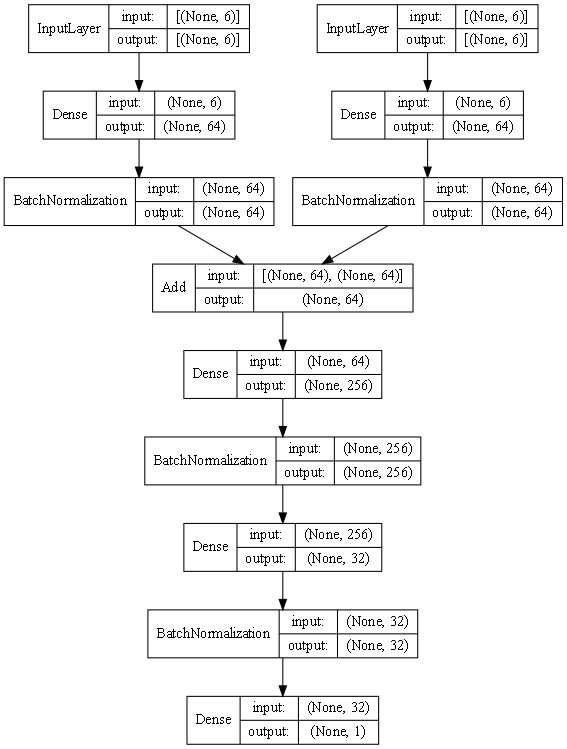

In [7]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=75)

In [8]:
trueValues, predValues, labels = make_data(35000, 6)

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit([trueValues, predValues], labels, epochs=500, verbose=1, validation_split = 0.5, callbacks=[stop_early])

Epoch 1/500
547/547 [==============================] - 11s 15ms/step - loss: 35.7794 - mean_absolute_error: 3.8944 - val_loss: 1.6765 - val_mean_absolute_error: 0.8333
Epoch 2/500
547/547 [==============================] - 8s 14ms/step - loss: 12.1864 - mean_absolute_error: 2.0737 - val_loss: 1.8679 - val_mean_absolute_error: 0.7364
Epoch 3/500
547/547 [==============================] - 8s 14ms/step - loss: 10.3237 - mean_absolute_error: 1.9049 - val_loss: 1.0754 - val_mean_absolute_error: 0.6552
Epoch 4/500
547/547 [==============================] - 7s 14ms/step - loss: 8.4130 - mean_absolute_error: 1.7688 - val_loss: 1.0501 - val_mean_absolute_error: 0.5795
Epoch 5/500
547/547 [==============================] - 7s 14ms/step - loss: 7.1501 - mean_absolute_error: 1.6607 - val_loss: 1.0274 - val_mean_absolute_error: 0.7179
Epoch 6/500
547/547 [==============================] - 8s 14ms/step - loss: 6.1934 - mean_absolute_error: 1.6259 - val_loss: 1.0263 - val_mean_absolute_error: 0.5355


547/547 [==============================] - 7s 14ms/step - loss: 3.0994 - mean_absolute_error: 1.3734 - val_loss: 0.3295 - val_mean_absolute_error: 0.4449
Epoch 51/500
547/547 [==============================] - 7s 13ms/step - loss: 3.0563 - mean_absolute_error: 1.3464 - val_loss: 0.1720 - val_mean_absolute_error: 0.2710
Epoch 52/500
547/547 [==============================] - 8s 14ms/step - loss: 3.2956 - mean_absolute_error: 1.4329 - val_loss: 0.5414 - val_mean_absolute_error: 0.6277
Epoch 53/500
547/547 [==============================] - 7s 14ms/step - loss: 3.3877 - mean_absolute_error: 1.4191 - val_loss: 0.1209 - val_mean_absolute_error: 0.2696
Epoch 54/500
547/547 [==============================] - 8s 14ms/step - loss: 3.0330 - mean_absolute_error: 1.3616 - val_loss: 0.0935 - val_mean_absolute_error: 0.2152
Epoch 55/500
547/547 [==============================] - 7s 14ms/step - loss: 3.1830 - mean_absolute_error: 1.3941 - val_loss: 0.4188 - val_mean_absolute_error: 0.6057
Epoch 56/50

547/547 [==============================] - 8s 14ms/step - loss: 2.8327 - mean_absolute_error: 1.3345 - val_loss: 0.4766 - val_mean_absolute_error: 0.4984
Epoch 100/500
547/547 [==============================] - 8s 14ms/step - loss: 2.8847 - mean_absolute_error: 1.3319 - val_loss: 0.0590 - val_mean_absolute_error: 0.1753
Epoch 101/500
547/547 [==============================] - 8s 14ms/step - loss: 3.1439 - mean_absolute_error: 1.3602 - val_loss: 0.0840 - val_mean_absolute_error: 0.1765
Epoch 102/500
547/547 [==============================] - 8s 14ms/step - loss: 2.9664 - mean_absolute_error: 1.3292 - val_loss: 0.2644 - val_mean_absolute_error: 0.3697
Epoch 103/500
547/547 [==============================] - 8s 14ms/step - loss: 3.2566 - mean_absolute_error: 1.4140 - val_loss: 0.0920 - val_mean_absolute_error: 0.2434
Epoch 104/500
547/547 [==============================] - 6s 12ms/step - loss: 2.8851 - mean_absolute_error: 1.3456 - val_loss: 0.1503 - val_mean_absolute_error: 0.3086
Epoch 

Epoch 148/500
547/547 [==============================] - 6s 11ms/step - loss: 2.6863 - mean_absolute_error: 1.2910 - val_loss: 0.0985 - val_mean_absolute_error: 0.1975
Epoch 149/500
547/547 [==============================] - 5s 9ms/step - loss: 2.7116 - mean_absolute_error: 1.2863 - val_loss: 0.1680 - val_mean_absolute_error: 0.3298
Epoch 150/500
547/547 [==============================] - 5s 9ms/step - loss: 2.8827 - mean_absolute_error: 1.3074 - val_loss: 0.3710 - val_mean_absolute_error: 0.4429
Epoch 151/500
547/547 [==============================] - 7s 13ms/step - loss: 2.7113 - mean_absolute_error: 1.2977 - val_loss: 0.0610 - val_mean_absolute_error: 0.1380
Epoch 152/500
547/547 [==============================] - 7s 13ms/step - loss: 2.8727 - mean_absolute_error: 1.3017 - val_loss: 0.1234 - val_mean_absolute_error: 0.2446
Epoch 153/500
547/547 [==============================] - 6s 11ms/step - loss: 2.4635 - mean_absolute_error: 1.2348 - val_loss: 0.1219 - val_mean_absolute_error: 0

Epoch 197/500
547/547 [==============================] - 5s 10ms/step - loss: 2.9039 - mean_absolute_error: 1.3084 - val_loss: 0.1664 - val_mean_absolute_error: 0.2665
Epoch 198/500
547/547 [==============================] - 6s 11ms/step - loss: 3.1578 - mean_absolute_error: 1.3787 - val_loss: 0.2309 - val_mean_absolute_error: 0.3884
Epoch 199/500
547/547 [==============================] - 7s 12ms/step - loss: 2.7208 - mean_absolute_error: 1.2797 - val_loss: 0.1005 - val_mean_absolute_error: 0.2027
Epoch 200/500
547/547 [==============================] - 5s 9ms/step - loss: 2.7822 - mean_absolute_error: 1.3110 - val_loss: 0.1746 - val_mean_absolute_error: 0.3153
Epoch 201/500
547/547 [==============================] - 5s 9ms/step - loss: 2.8972 - mean_absolute_error: 1.3073 - val_loss: 0.0582 - val_mean_absolute_error: 0.1467
Epoch 202/500
547/547 [==============================] - 7s 12ms/step - loss: 2.8998 - mean_absolute_error: 1.3132 - val_loss: 0.0761 - val_mean_absolute_error: 0

Epoch 246/500
547/547 [==============================] - 7s 13ms/step - loss: 2.8911 - mean_absolute_error: 1.3259 - val_loss: 0.1050 - val_mean_absolute_error: 0.2144
Epoch 247/500
547/547 [==============================] - 7s 12ms/step - loss: 2.7268 - mean_absolute_error: 1.2745 - val_loss: 0.0796 - val_mean_absolute_error: 0.1538


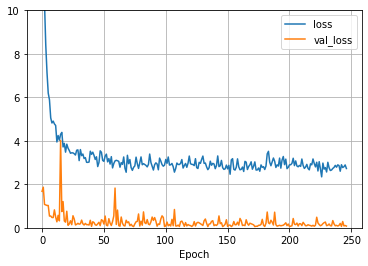

In [10]:
plot_loss(history)

In [11]:
model.save('models/loss_fn_6_1')

INFO:tensorflow:Assets written to: models/loss_fn_6_1\assets


C:\Users\saatw\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
